In [27]:
from keras.layers import LSTM
from keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#standardize the data
from sklearn.preprocessing import StandardScaler

In [28]:
def load_data(path):
    df = pd.read_csv(path)
    print(df.info())
    #convert the date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    print(df.head())
    print(df.info())
    return df


In [29]:
path='/Users/rianrachmanto/pypro/data/esp_new.csv'
df = load_data(path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202978 entries, 0 to 202977
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Well             202978 non-null  object 
 1   Date             202978 non-null  object 
 2   Hours_Online     91217 non-null   float64
 3   Freq             79585 non-null   float64
 4   Ampere           83274 non-null   float64
 5   Volt             76026 non-null   float64
 6   Press_Discharge  57558 non-null   float64
 7   TM               39661 non-null   float64
 8   Vibration        36035 non-null   float64
 9   Gross_Rate       85310 non-null   float64
dtypes: float64(8), object(2)
memory usage: 15.5+ MB
None
  Well       Date  Hours_Online  Freq  Ampere   Volt  Press_Discharge     TM  \
0  BC1 2011-09-02          24.0   NaN    19.2  343.2              NaN  175.0   
1  BC1 2011-09-03          24.0   NaN    18.3  339.6              NaN  177.4   
2  BC1 2011-09-04          

In [30]:
def select_freq(df, well_name):
    # Filter the DataFrame for the given well name
    df_freq = df[df['Well'] == well_name][['Well', 'Date', 'Freq']]
    print(df_freq.head())
    return df_freq


In [31]:
df_freq = select_freq(df, 'BS3')

     Well       Date  Freq
9277  BS3 2011-09-01   NaN
9278  BS3 2011-09-02   NaN
9279  BS3 2011-09-03   NaN
9280  BS3 2011-09-04   NaN
9281  BS3 2011-09-05   NaN


In [32]:
def train_test (df_freq):
    #split based on length of the data with 80% training and 20% testing
    train_size = int(len(df_freq) * 0.8)
    test_size = len(df_freq) - train_size
    train, test = df_freq.iloc[0:train_size], df_freq.iloc[train_size:len(df_freq)]
    print(train.shape, test.shape)
    print(train.head())
    return train, test

In [33]:
train, test = train_test(df_freq)

(3711, 3) (928, 3)
     Well       Date  Freq
9277  BS3 2011-09-01   NaN
9278  BS3 2011-09-02   NaN
9279  BS3 2011-09-03   NaN
9280  BS3 2011-09-04   NaN
9281  BS3 2011-09-05   NaN


In [34]:
def clean_train(train):
    #drop all the missing values
    train = train.dropna()
    print(train.shape)
    print(train.head())
    return train

def clean_test(test):
    #drop all the missing values
    test = test.dropna()
    print(test.shape)
    print(test.head())
    return test

In [35]:
train = clean_train(train)
test = clean_test(test)

(677, 3)
     Well       Date  Freq
9891  BS3 2013-05-07  60.0
9892  BS3 2013-05-08  60.0
9893  BS3 2013-05-09  60.0
9894  BS3 2013-05-10  60.0
9895  BS3 2013-05-11  60.0
(571, 3)
      Well       Date  Freq
13135  BS3 2022-03-25  43.0
13136  BS3 2022-03-26  45.0
13142  BS3 2022-04-01  53.0
13143  BS3 2022-04-02  53.0
13144  BS3 2022-04-03  53.0


In [36]:
#plot the data as time series
def plot_data(train):
    plt.figure(figsize=(12,6))
    plt.plot(train['Date'], train['Freq'])
    plt.title('Frequency vs Time')
    plt.ylabel('Frequency')
    plt.xlabel('Date')
    plt.show()

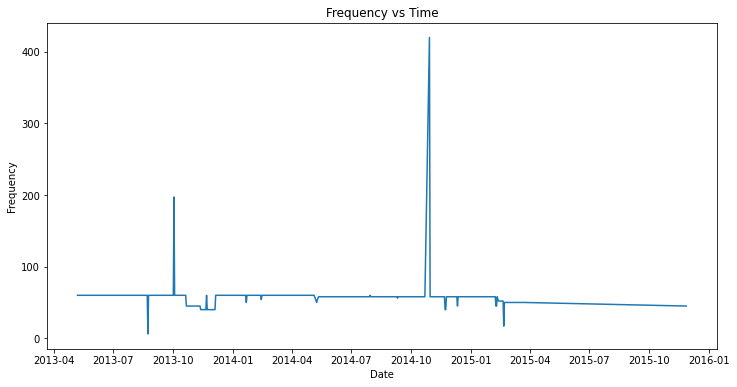

In [37]:
plot_data(train)

In [42]:
#preprocess train data to standardize the data
def preprocess_train(train, test):
    # Create copies of the input DataFrames to avoid modifying original data
    scaled_train = train.copy()
    scaled_test = test.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training data
    scaler = scaler.fit(train[['Freq']])

    # Transform the 'Freq' column for both training and testing data
    scaled_train['Freq'] = scaler.transform(train[['Freq']])
    scaled_test['Freq'] = scaler.transform(test[['Freq']])

    print(scaled_train.head())
    return scaled_train, scaled_test


In [43]:
scaled_train,scaled_test = preprocess_train(train,test)

     Well       Date      Freq
9891  BS3 2013-05-07  0.131845
9892  BS3 2013-05-08  0.131845
9893  BS3 2013-05-09  0.131845
9894  BS3 2013-05-10  0.131845
9895  BS3 2013-05-11  0.131845


In [46]:
import numpy as np

def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps):
        # Define the end of the sequence
        end_ix = i + n_steps
        # Gather input and output parts of the pattern
        seq_x = data[i:end_ix]
        X.append(seq_x)
    return np.array(X)


In [47]:
# Assuming you have already called preprocess_train and obtained scaled_train and scaled_test
n_steps = 10
# Convert DataFrame to numpy array for easier manipulation
train_freq = scaled_train['Freq'].values
test_freq = scaled_test['Freq'].values

# Create sequences
X_train = create_sequences(train_freq, n_steps)
X_test = create_sequences(test_freq, n_steps)

# Print the shapes to understand the dimensions
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (667, 10)
Test data shape: (561, 10)


In [48]:
# Reshape the data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Reshaped training data shape:", X_train.shape)
print("Reshaped test data shape:", X_test.shape)


Reshaped training data shape: (667, 10, 1)
Reshaped test data shape: (561, 10, 1)


In [49]:
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

def build_autoencoder(timesteps, n_features):
    # Encoder
    encoder = Sequential()
    encoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=False))
    encoder.add(RepeatVector(timesteps))  # This helps to repeat the context vector for the decoder

    # Decoder
    decoder = Sequential()
    decoder.add(LSTM(32, activation='relu', return_sequences=True))
    decoder.add(TimeDistributed(Dense(n_features)))  # Wraps Dense layer to output sequence

    # Autoencoder
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Define your autoencoder model
timesteps = 10  # Number of time steps in each sequence
n_features = 1  # You have one feature per time step (Freq)
autoencoder = build_autoencoder(timesteps, n_features)
autoencoder.summary()  # Print the model architecture


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 32)            4352      
                                                                 
 sequential_1 (Sequential)   (None, 10, 1)             8353      
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
19/19 [==============================] - 26s 935ms/step - loss: 1.0790 - val_loss: 0.1908
Epoch 2/50
19/19 [==============================] - 8s 405ms/step - loss: 1.0226 - val_loss: 0.1020
Epoch 3/50
19/19 [==============================] - 8s 409ms/step - loss: 0.9467 - val_loss: 0.0931
Epoch 4/50
19/19 [==============================] - 8s 410ms/step - loss: 0.9247 - val_loss: 0.0905
Epoch 5/50
19/19 [==============================] - 8s 409ms/step - loss: 0.9199 - val_loss: 0.0877
Epoch 6/50
19/19 [==============================] - 8s 410ms/step - loss: 1.0152 - val_loss: 0.0859
Epoch 7/50
19/19 [==============================] - 8s 408ms/step - loss: 0.9055 - val_loss: 0.0833
Epoch 8/50
19/19 [==============================] - 8s 409ms/step - loss: 0.8983 - val_loss: 0.0814
Epoch 9/50
19/19 [==============================] - 8s 410ms/step - loss: 0.8921 - val_loss: 0.0816
Epoch 10/50
19/19 [==============================] - 8s 410ms/step - loss: 0.8849 - val_loss: 0.080

In [51]:
import numpy as np

# Assuming X_test is your test dataset already prepared
predicted = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(predicted - X_test), axis=1)


18/18 [==============================] - 5s 153ms/step


In [52]:
threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)
print("Anomaly detection threshold:", threshold)


Anomaly detection threshold: 1.2016736171502953


In [53]:
anomalies = reconstruction_errors > threshold
print("Number of detected anomalies:", np.sum(anomalies))


Number of detected anomalies: 10


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reconstruction_errors and threshold are already defined
anomalies = reconstruction_errors > threshold
any_anomalies = np.any(anomalies)  # Check if there are any True values in anomalies


In [60]:
print("Length of time_steps:", len(time_steps))
print("Length of reconstruction_errors:", len(reconstruction_errors))
print("Length of anomalies array:", len(anomalies))


Length of time_steps: 561
Length of reconstruction_errors: 561
Length of anomalies array: 561


In [62]:
# Assuming reconstruction_errors and threshold are already defined
anomalies = reconstruction_errors > threshold
print("Type of anomalies:", anomalies.dtype)  # Should output dtype('bool')
print("Sample of anomalies array:", anomalies[:10])  # See a few values


Type of anomalies: bool
Sample of anomalies array: [[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [66]:
print("Reconstruction Errors Shape:", reconstruction_errors.shape)


Reconstruction Errors Shape: (561, 1)


In [67]:
reconstruction_errors = reconstruction_errors.flatten()


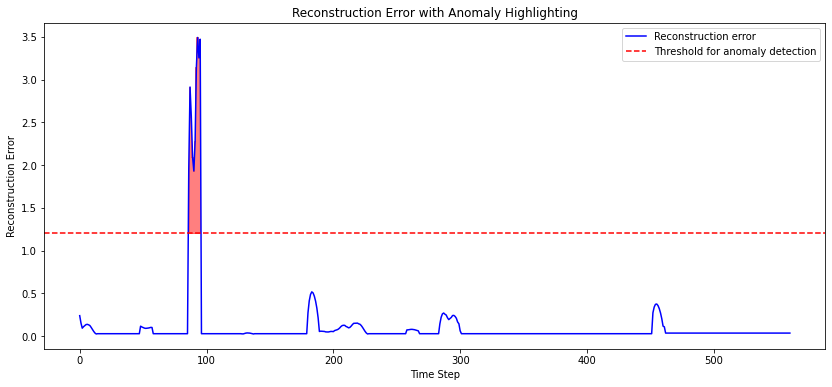

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reconstruction_errors and threshold are already defined
anomalies = (reconstruction_errors > threshold).flatten()
time_steps = np.arange(len(reconstruction_errors))

plt.figure(figsize=(14, 6))

# Plot the entire reconstruction error line
plt.plot(time_steps, reconstruction_errors, label='Reconstruction error', color='blue')

# Overlay anomalies in red
plt.fill_between(time_steps, reconstruction_errors, threshold, where=anomalies, color='red', step='pre', alpha=0.5)

# Add threshold line
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold for anomaly detection')

plt.title('Reconstruction Error with Anomaly Highlighting')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()
